###Data Collection and Preprocessing

In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Load NASA Datasets
df_nasa_train = pd.read_csv('train_FD001.txt', delim_whitespace=True, header=None)
df_nasa_test = pd.read_csv('test_FD001.txt', delim_whitespace=True, header=None)
df_rul = pd.read_csv('RUL_FD001.txt', header=None, names=['RUL'])

# Add column names for NASA datasets
df_nasa_train.columns = ['unit_number', 'time_in_cycles', 'op_setting_1', 'op_setting_2', 'op_setting_3'] + [
    f'sensor_measurement_{i}' for i in range(1, 22)
]
df_nasa_test.columns = df_nasa_train.columns

# Calculate RUL for training data
df_nasa_train['RUL'] = df_nasa_train.groupby('unit_number')['time_in_cycles'].transform(lambda x: x.max() - x)

# Add RUL to test data
df_nasa_test = df_nasa_test.copy()
df_nasa_test['RUL'] = df_rul['RUL']

# Normalize features
scaler = MinMaxScaler()
sensor_columns = [f'sensor_measurement_{i}' for i in range(1, 22)]
df_nasa_train[sensor_columns] = scaler.fit_transform(df_nasa_train[sensor_columns])

print("Preprocessing Complete: NASA datasets normalized.")


<ipython-input-1-0d55dad9b541>:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_nasa_train = pd.read_csv('train_FD001.txt', delim_whitespace=True, header=None)
<ipython-input-1-0d55dad9b541>:6: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_nasa_test = pd.read_csv('test_FD001.txt', delim_whitespace=True, header=None)


Preprocessing Complete: NASA datasets normalized.


###Visualizing Distributions
NASA Dataset: Sensor Measurements and RUL

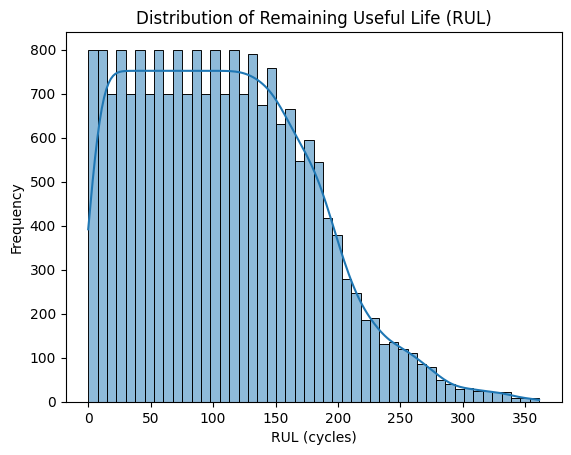

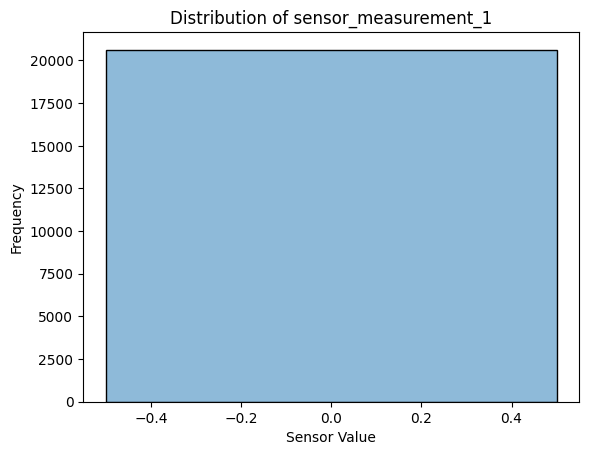

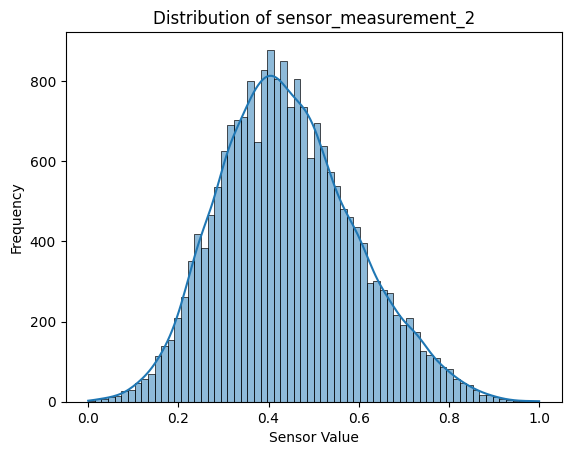

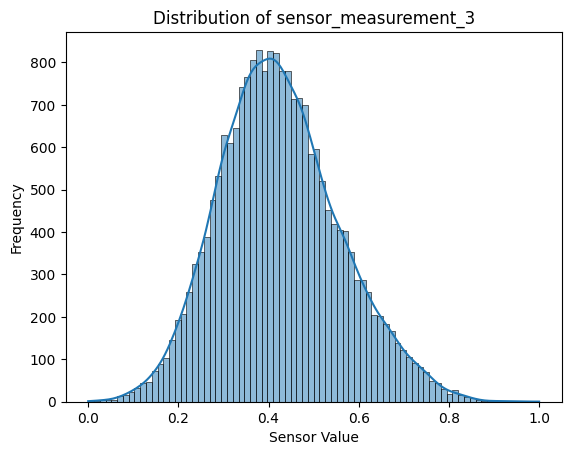

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

# Distribution of Remaining Useful Life (RUL) in NASA Train Dataset
sns.histplot(df_nasa_train['RUL'], kde=True)
plt.title('Distribution of Remaining Useful Life (RUL)')
plt.xlabel('RUL (cycles)')
plt.ylabel('Frequency')
plt.show()

# Distribution of Sensor Measurement Example
for sensor in ['sensor_measurement_1', 'sensor_measurement_2', 'sensor_measurement_3']:
    sns.histplot(df_nasa_train[sensor], kde=True)
    plt.title(f'Distribution of {sensor}')
    plt.xlabel('Sensor Value')
    plt.ylabel('Frequency')
    plt.show()


###Time-Series Analysis
NASA Dataset: Trends in Sensor Data

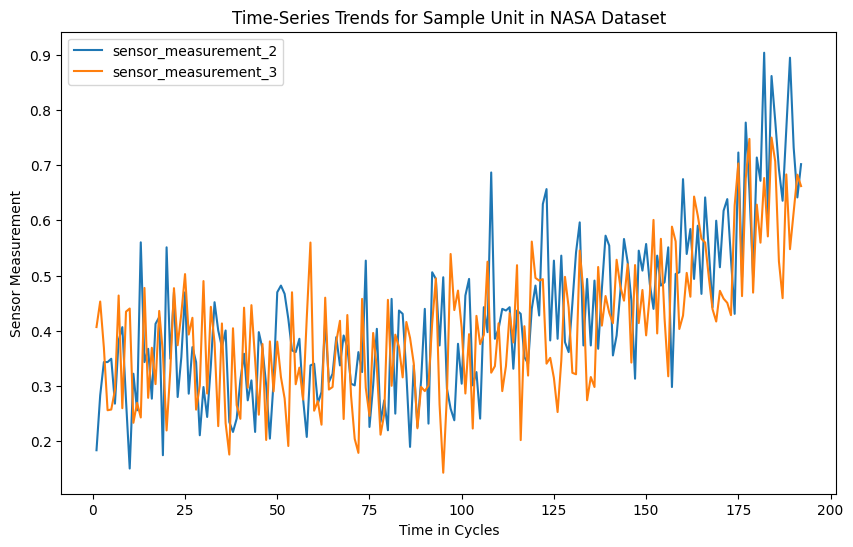

In [3]:
# Time-Series Trends for Sensors in a Sample Unit
sample_unit = df_nasa_train[df_nasa_train['unit_number'] == 1]
plt.figure(figsize=(10, 6))
for sensor in ['sensor_measurement_2', 'sensor_measurement_3']:  # Adjust based on critical sensors
    plt.plot(sample_unit['time_in_cycles'], sample_unit[sensor], label=sensor)
plt.xlabel('Time in Cycles')
plt.ylabel('Sensor Measurement')
plt.title('Time-Series Trends for Sample Unit in NASA Dataset')
plt.legend()
plt.show()


###Analytical Methods and Model Selection

In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import numpy as np

# Prepare NASA data for TCN
sequence_length = 30  # TCN sequence length
sensor_columns = [f'sensor_measurement_{i}' for i in range(1, 22)]  # List of sensor columns

def create_sequences(data, target, seq_length):
    """
    Creates sequences of data and corresponding targets for time-series modeling.

    Parameters:
    - data (numpy array): Array of input features.
    - target (numpy array): Array of target values (RUL).
    - seq_length (int): Length of each input sequence.

    Returns:
    - sequences (numpy array): 3D array of input sequences.
    - targets (numpy array): Array of target values for each sequence.
    """
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        targets.append(target[i + seq_length])
    return np.array(sequences), np.array(targets)

# Extract input features and target from the dataset
X = df_nasa_train[sensor_columns].values  # Sensor data
y = df_nasa_train['RUL'].values           # Remaining Useful Life (RUL)

# Create sequences for NASA sensor data
X_seq, y_seq = create_sequences(X, y, sequence_length)

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

# Build TCN model
def build_tcn_model(input_shape):
    """
    Builds and compiles a Temporal Convolutional Network (TCN) model.

    Parameters:
    - input_shape (tuple): Shape of the input data (sequence_length, number_of_features).

    Returns:
    - model: Compiled TCN model.
    """
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv1D(filters=64, kernel_size=3, dilation_rate=1, activation='relu', padding='causal'),
        layers.Conv1D(filters=64, kernel_size=3, dilation_rate=2, activation='relu', padding='causal'),
        layers.Conv1D(filters=64, kernel_size=3, dilation_rate=4, activation='relu', padding='causal'),
        layers.GlobalAveragePooling1D(),
        layers.Dense(128, activation='relu'),
        layers.Dense(1)  # Output RUL prediction
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Define input shape for the model
input_shape = (sequence_length, X_seq.shape[2])  # (sequence_length, number_of_features)

# Train TCN model
tcn_model = build_tcn_model(input_shape)
history = tcn_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32)

# Evaluate the model
val_loss, val_mae = tcn_model.evaluate(X_val, y_val)
print(f"Validation Loss: {val_loss}, Validation MAE: {val_mae}")

Epoch 1/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 6308.8911 - mae: 62.0744 - val_loss: 2418.4519 - val_mae: 36.5723
Epoch 2/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 2425.2952 - mae: 36.7149 - val_loss: 2367.2061 - val_mae: 36.2273
Epoch 3/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 2298.8501 - mae: 35.6628 - val_loss: 2221.7703 - val_mae: 34.9934
Epoch 4/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 2212.3879 - mae: 34.6589 - val_loss: 2044.9585 - val_mae: 33.7783
Epoch 5/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 1953.0183 - mae: 32.1949 - val_loss: 1971.0088 - val_mae: 34.1151
Epoch 6/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 1755.5236 - mae: 30.1429 - val_loss: 1697.6718 - val_mae: 29.9714
Epoch 7/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 1750.2291 - mae: 29.5872 - val_loss: 1665.8619 - val_mae: 29.7577
Epoch 8/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 1666.9956 - mae: 28.9337 - val_loss: 1889.7645 - v

###Comparative Analysis

In [8]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Train Random Forest model on aggregated data
X_rf = df_nasa_train[sensor_columns]
y_rf = df_nasa_train['RUL']
X_train_rf, X_val_rf, y_train_rf, y_val_rf = train_test_split(X_rf, y_rf, test_size=0.2, random_state=42)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_rf, y_train_rf)
y_pred_rf = rf_model.predict(X_val_rf)

# Evaluate
rmse_rf = mean_squared_error(y_val_rf, y_pred_rf, squared=False)
r2_rf = r2_score(y_val_rf, y_pred_rf)
print(f"Random Forest RMSE: {rmse_rf}, R^2: {r2_rf}")

# Evaluate TCN
val_loss, val_mae = tcn_model.evaluate(X_val, y_val)
print(f"TCN Validation Loss: {val_loss}, Validation MAE: {val_mae}")


Random Forest RMSE: 41.40888285948394, R^2: 0.6246941408226915
 10/129 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1247.6461 - mae: 25.0212

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1147.6155 - mae: 24.2164
TCN Validation Loss: 1136.9027099609375, Validation MAE: 24.057819366455078


###Explanation Using SHAP

100%|===================| 4123/4127 [12:33<00:00]       

Generating SHAP Summary Plot for Random Forest...


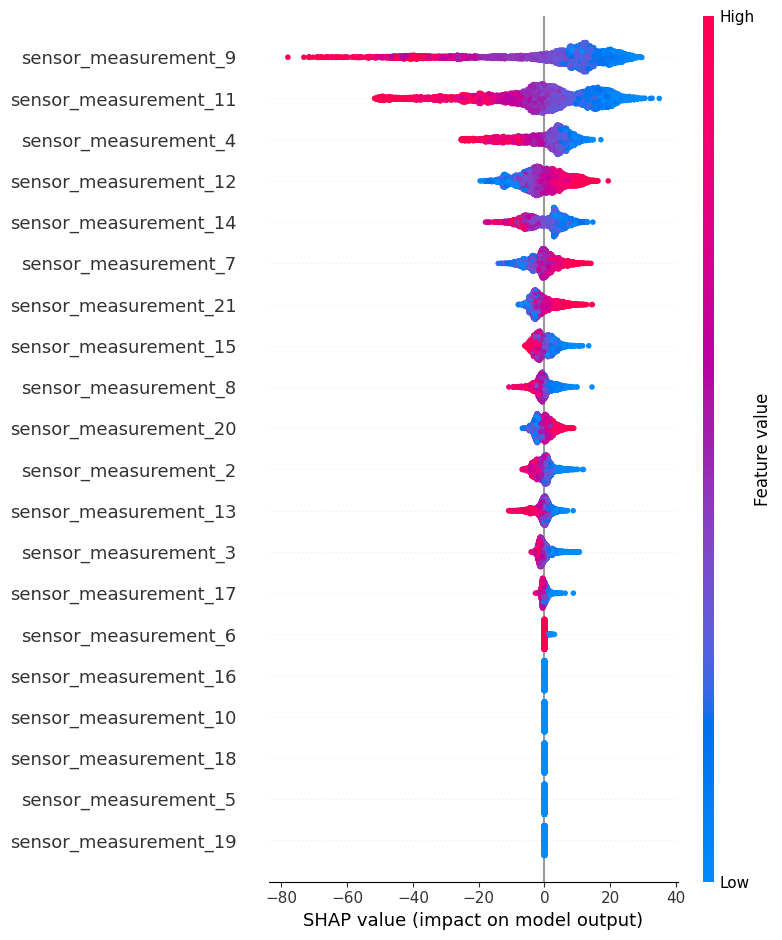

Generating SHAP Dependence Plot for sensor_measurement_2...


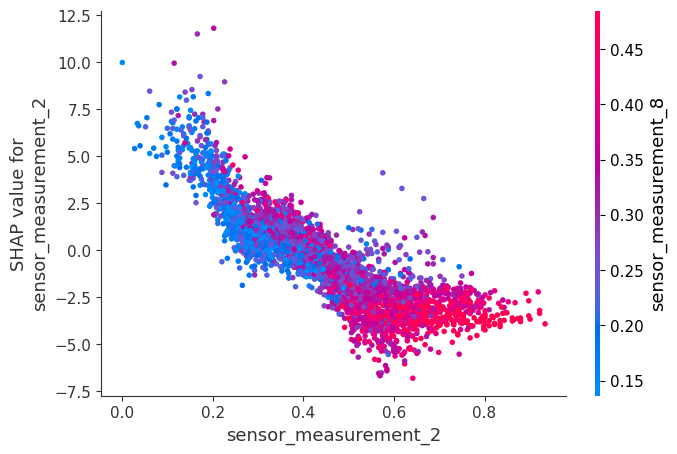

In [9]:
import shap

# Validate the shape of the input data
if X_val_rf.shape[1] != X_train_rf.shape[1]:
    raise ValueError("Feature mismatch between training and validation data. Ensure that the features are consistent.")

# Initialize SHAP Explainer for Random Forest
explainer_rf = shap.Explainer(rf_model, X_val_rf)

# Compute SHAP values with additivity check disabled
shap_values_rf = explainer_rf(X_val_rf, check_additivity=False)

# Convert SHAP values to array format
shap_values_rf_array = shap_values_rf.values

# Display SHAP Summary Plot
print("Generating SHAP Summary Plot for Random Forest...")
shap.summary_plot(shap_values_rf_array, X_val_rf, feature_names=X_rf.columns)

# Display SHAP Dependence Plot for a specific feature
feature_to_plot = 'sensor_measurement_2'  # Replace with any feature you want to analyze
print(f"Generating SHAP Dependence Plot for {feature_to_plot}...")
shap.dependence_plot(feature_to_plot, shap_values_rf_array, X_val_rf, feature_names=X_rf.columns)
